Vamos tentar outras estrategias do modelo já que na v1 correu mal

In [7]:
import pandas as pd
import numpy as np


# Lista final de features que o modelo treinado espera, NA ORDEM CORRETA.
# Esta lista foi definida no final da sua EDA.
FEATURES_FINAIS_PARA_MODELO = [
    'total_issues_created_log',
    'issue_participation_log',
    'issue_resolution_rate_created_log',
    'total_review_activity_log',
    'merged_ratio_log',
    'sum_lines_added_log',
    'interval',
    'branches_created',
]

# Epsilon para evitar divisão por zero nos ratios
EPSILON = 1e-6

# Colunas a serem removidas inicialmente se existirem
COLS_TO_DROP_INITIAL = [
    "project_id",
    "group_id",
    "mention_handle",
    "last_minute_commits", # Foi identificada como sempre zero
    "sum_lines_per_commit" # Foi removida devido à alta correlação/redundância
]

In [8]:
# ==============================================================================
# FUNÇÃO DE PRÉ-PROCESSAMENTO
# ==============================================================================

def preprocess_data_for_prediction(df_new_raw):
    df_processed = df_new_raw.copy()
    print(f"Pré-processamento: Dimensões iniciais dos novos dados: {df_processed.shape}")

    # --- 1. Remover colunas irrelevantes ---
    print("Pré-processamento: Removendo colunas irrelevantes...")
    for col in COLS_TO_DROP_INITIAL:
        if col in df_processed.columns:
            df_processed.drop(columns=[col], inplace=True)
            print(f"  Coluna '{col}' removida.")
    print(f"Pré-processamento: Dimensões após remoção inicial: {df_processed.shape}")


    # --- 2. Criar features _log diretamente necessárias para o modelo ---
    # (Estas são features que entram no modelo como _log e não são derivadas de ratios complexos)
    print("Pré-processamento: Criando features _log diretas...")

    # sum_lines_added_log
    if 'sum_lines_added' in df_processed.columns:
        df_processed['sum_lines_added_log'] = np.log1p(df_processed['sum_lines_added'])
        print("  Feature 'sum_lines_added_log' criada.")
    else:
        print("  AVISO: Coluna 'sum_lines_added' não encontrada. 'sum_lines_added_log' não será criada diretamente aqui (será preenchida no final se faltar).")

    # total_issues_created_log
    if 'total_issues_created' in df_processed.columns:
        df_processed['total_issues_created_log'] = np.log1p(df_processed['total_issues_created'])
        print("  Feature 'total_issues_created_log' criada.")
    else:
        print("  AVISO: Coluna 'total_issues_created' não encontrada. 'total_issues_created_log' não será criada diretamente aqui.")

    # issue_participation_log
    if 'issue_participation' in df_processed.columns:
        df_processed['issue_participation_log'] = np.log1p(df_processed['issue_participation'])
        print("  Feature 'issue_participation_log' criada.")
    else:
        print("  AVISO: Coluna 'issue_participation' não encontrada. 'issue_participation_log' não será criada diretamente aqui.")


    # --- 3. Engenharia de Features (Ratios e Combinadas com Log) ---
    print("Pré-processamento: Iniciando engenharia de features (ratios, combinadas)...")

    # Merged Ratio Log
    if 'merged_requests' in df_processed.columns and 'total_merge_requests' in df_processed.columns:
        merged_ratio_raw = df_processed['merged_requests'] / (df_processed['total_merge_requests'] + EPSILON)
        df_processed['merged_ratio_log'] = np.log1p(merged_ratio_raw)
        print("  Feature 'merged_ratio_log' criada.")
    else:
        print("  AVISO: Colunas 'merged_requests' ou 'total_merge_requests' não encontradas. 'merged_ratio_log' não será criada (será preenchida no final se faltar).")
        df_processed['merged_ratio_log'] = np.log1p(0) # Preenchimento padrão se faltar

    # Issue Resolution Rate Created Log
    if 'issues_resolved' in df_processed.columns and 'total_issues_created' in df_processed.columns:
        issue_res_rate_created_raw = df_processed['issues_resolved'] / (df_processed['total_issues_created'] + EPSILON)
        df_processed['issue_resolution_rate_created_log'] = np.log1p(issue_res_rate_created_raw)
        print("  Feature 'issue_resolution_rate_created_log' criada.")
    else:
        print("  AVISO: Colunas 'issues_resolved' ou 'total_issues_created' não encontradas. 'issue_resolution_rate_created_log' não será criada (será preenchida no final se faltar).")
        df_processed['issue_resolution_rate_created_log'] = np.log1p(0) # Preenchimento padrão

    # Total Review Activity Log
    if 'review_comments_given' in df_processed.columns and 'review_comments_received' in df_processed.columns:
        total_review_raw = df_processed['review_comments_given'] + df_processed['review_comments_received']
        df_processed['total_review_activity_log'] = np.log1p(total_review_raw)
        print("  Feature 'total_review_activity_log' criada.")
    else:
        print("  AVISO: Colunas 'review_comments_given' ou 'review_comments_received' não encontradas. 'total_review_activity_log' não será criada (será preenchida no final se faltar).")
        df_processed['total_review_activity_log'] = np.log1p(0) # Preenchimento padrão

    # --- 4. Garantir que todas as features finais estão presentes e selecionar ---
    #    As features 'interval' e 'branches_created' são usadas como estão (se existirem).
    print("Pré-processamento: Selecionando e ordenando features finais...")
    missing_features_in_final_step = []
    for final_feature in FEATURES_FINAIS_PARA_MODELO:
        if final_feature not in df_processed.columns:
            print(f"  AVISO FINAL: Feature final '{final_feature}' não encontrada nos dados processados. Preenchendo com 0.")
            df_processed[final_feature] = 0 # Ou outra estratégia de imputação (ex: média do treino)
            missing_features_in_final_step.append(final_feature)
    
    if missing_features_in_final_step:
        print(f"  Resumo de features finais que foram preenchidas com 0: {missing_features_in_final_step}")

    # Selecionar apenas as colunas finais na ordem correta
    # Adiciona colunas faltantes com 0 se, mesmo após tudo, elas não existirem (caso extremo)
    for col in FEATURES_FINAIS_PARA_MODELO:
        if col not in df_processed:
            df_processed[col] = 0

    df_model_ready = df_processed[FEATURES_FINAIS_PARA_MODELO]
    print(f"Pré-processamento: Dimensões finais dos dados prontos para o modelo (antes do scaler): {df_model_ready.shape}")
    
    return df_model_ready


In [9]:
import pandas as pd

df = pd.read_csv("student_features_interval_all.csv")  # Substitua pelo nome do seu arquivo

In [10]:
X_raw = df.drop(columns=["Final Grade"])  # Features
y = df["Final Grade"]  # Target

In [11]:
X = preprocess_data_for_prediction(X_raw)


Pré-processamento: Dimensões iniciais dos novos dados: (1077, 20)
Pré-processamento: Removendo colunas irrelevantes...
  Coluna 'project_id' removida.
  Coluna 'group_id' removida.
  Coluna 'mention_handle' removida.
  Coluna 'last_minute_commits' removida.
  Coluna 'sum_lines_per_commit' removida.
Pré-processamento: Dimensões após remoção inicial: (1077, 15)
Pré-processamento: Criando features _log diretas...
  Feature 'sum_lines_added_log' criada.
  Feature 'total_issues_created_log' criada.
  Feature 'issue_participation_log' criada.
Pré-processamento: Iniciando engenharia de features (ratios, combinadas)...
  Feature 'merged_ratio_log' criada.
  Feature 'issue_resolution_rate_created_log' criada.
  Feature 'total_review_activity_log' criada.
Pré-processamento: Selecionando e ordenando features finais...
Pré-processamento: Dimensões finais dos dados prontos para o modelo (antes do scaler): (1077, 8)


In [12]:
from sklearn.preprocessing import KBinsDiscretizer

# Estratificação por quantis --> por causa do desbalanceamento
stratifier = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_strat = stratifier.fit_transform(y.values.reshape(-1, 1)).ravel()

In [13]:
from sklearn.model_selection import train_test_split

# Dividir em treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_strat, random_state=42
)

In [16]:
! pip install lightgbm

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)


In [19]:
import lightgbm
print(lightgbm.__version__)

4.6.0


In [22]:
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation

model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

In [23]:
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)

c:\Users\cataf\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não conseguiu localizar o ficheiro especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\cataf\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\cataf\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cataf\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\cataf\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 8
[LightGBM] [Info] Start training from score 13.478513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=1000,
              random_state=42)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nDesempenho no conjunto de teste:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Desempenho no conjunto de teste:
MAE: 1.57
RMSE: 2.24


In [25]:
# só para ver mais ou menos onde esta a errar
from sklearn.metrics import mean_absolute_error

# Definir faixas de notas apenas para análise do erro por região
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]

# Criar categorias temporárias só para análise
y_test_bins = pd.cut(y_test, bins=bins, labels=labels, right=True)
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "faixa": y_test_bins
})

# MAE por faixa (diagnóstico)
mae_por_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
contagem_por_faixa = results_df["faixa"].value_counts().sort_index()

print("\n📊 MAE por faixa de nota:")
print(mae_por_faixa)

print("\n📊 Nº de exemplos por faixa:")
print(contagem_por_faixa)



📊 MAE por faixa de nota:
faixa
Muito baixa    2.976679
Baixa          1.111897
Média          1.590419
Alta           1.668367
Muito alta     2.195413
dtype: float64

📊 Nº de exemplos por faixa:
faixa
Muito baixa     9
Baixa          83
Média          86
Alta           30
Muito alta      4
Name: count, dtype: int64


C:\Users\cataf\AppData\Local\Temp\ipykernel_24500\4143451678.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
C:\Users\cataf\AppData\Local\Temp\ipykernel_24500\4143451678.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


sample_weight --> Dar mais importância (peso) aos exemplos raros ou difíceis durante o treino do modelo.

In [42]:
# === Criar faixas e pesos ===
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_train_bins = pd.cut(y_train, bins=bins, labels=labels)

# Define os pesos
pesos_por_faixa = {
    "Muito baixa": 5,
    "Baixa": 1,
    "Média": 1,
    "Alta": 2,
    "Muito alta": 5
}
sample_weights = y_train_bins.map(pesos_por_faixa)

# === Modelo LightGBM com pesos ===
model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(50)
    ]
)

# === Avaliação final ===
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 8
[LightGBM] [Info] Start training from score 12.886972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [43]:
print(f"\nDesempenho com sample_weight:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Desempenho com sample_weight:
MAE: 1.68
RMSE: 2.70


In [44]:
# Assumindo que já tens y_test e y_pred após treino com sample_weight

import pandas as pd
from sklearn.metrics import mean_absolute_error

# Definir faixas
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_test_bins = pd.cut(y_test, bins=bins, labels=labels)

# Criar DataFrame de resultados
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "faixa": y_test_bins
})

# MAE por faixa
mae_por_faixa = results_df.groupby("faixa").apply(
    lambda g: mean_absolute_error(g["y_true"], g["y_pred"])
)
contagem_por_faixa = results_df["faixa"].value_counts().sort_index()

print("--->  MAE por faixa (modelo com sample_weight):")
print(mae_por_faixa)

print("\n---> Nº de exemplos por faixa:")
print(contagem_por_faixa)


--->  MAE por faixa (modelo com sample_weight):
faixa
Muito baixa    2.902038
Baixa          1.319463
Média          1.454750
Alta           1.519619
Muito alta     1.536708
dtype: float64

---> Nº de exemplos por faixa:
faixa
Muito baixa     9
Baixa          83
Média          86
Alta           30
Muito alta      4
Name: count, dtype: int64


C:\Users\cataf\AppData\Local\Temp\ipykernel_24500\1479867575.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(
C:\Users\cataf\AppData\Local\Temp\ipykernel_24500\1479867575.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(


melhoraram todos (menos uma pequena diferença no baixa)

In [45]:
import matplotlib.pyplot as plt

# Importância das features
importances = model.feature_importances_
feature_names = X.columns

# Ordenar
indices = np.argsort(importances)[::-1]

for i in indices:
    print(f"{feature_names[i]}: {importances[i]}")

issue_participation_log: 1480
total_review_activity_log: 1443
branches_created: 866
total_issues_created_log: 676
issue_resolution_rate_created_log: 665
merged_ratio_log: 656
interval: 553
sum_lines_added_log: 487


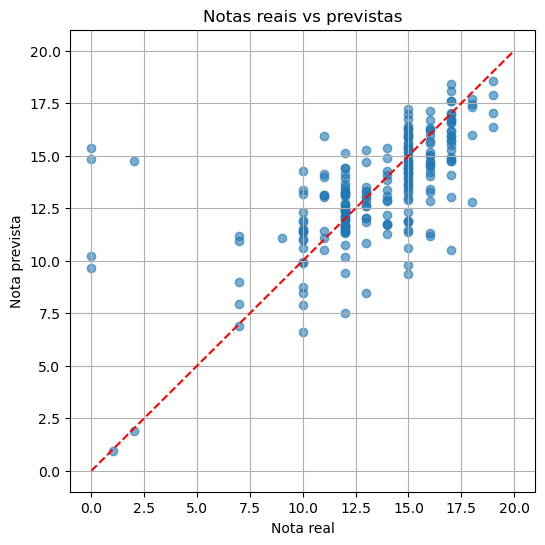

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, 20], [0, 20], 'r--')  # Linha ideal
plt.xlabel("Nota real")
plt.ylabel("Nota prevista")
plt.title("Notas reais vs previstas")
plt.grid(True)
plt.show()


vamos tentar com outra afinação

In [ ]:
#pesos_por_faixa = {
#    "Muito baixa": 6,
#    "Baixa": 1,
#    "Média": 1,
#    "Alta": 2,
#    "Muito alta": 6
#}

In [ ]:
sample_weights = y_train_bins.map(pesos_por_faixa)

# === Modelo LightGBM com pesos ===
model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(50)
    ]
)

# === Avaliação final ===
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [39]:
print(f"\nDesempenho com sample_weight:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Desempenho com sample_weight:
MAE: 1.83
RMSE: 2.82


In [40]:
# Assumindo que já tens y_test e y_pred após treino com sample_weight

import pandas as pd
from sklearn.metrics import mean_absolute_error

# Definir faixas
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_test_bins = pd.cut(y_test, bins=bins, labels=labels)

# Criar DataFrame de resultados
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "faixa": y_test_bins
})

# MAE por faixa
mae_por_faixa = results_df.groupby("faixa").apply(
    lambda g: mean_absolute_error(g["y_true"], g["y_pred"])
)
contagem_por_faixa = results_df["faixa"].value_counts().sort_index()

print("--->  MAE por faixa (modelo com sample_weight):")
print(mae_por_faixa)

print("\n---> Nº de exemplos por faixa:")
print(contagem_por_faixa)


--->  MAE por faixa (modelo com sample_weight):
faixa
Muito baixa    2.885624
Baixa          1.402537
Média          1.599004
Alta           1.902851
Muito alta     1.930816
dtype: float64

---> Nº de exemplos por faixa:
faixa
Muito baixa     9
Baixa          83
Média          86
Alta           30
Muito alta      4
Name: count, dtype: int64


C:\Users\cataf\AppData\Local\Temp\ipykernel_24500\1479867575.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(
C:\Users\cataf\AppData\Local\Temp\ipykernel_24500\1479867575.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(


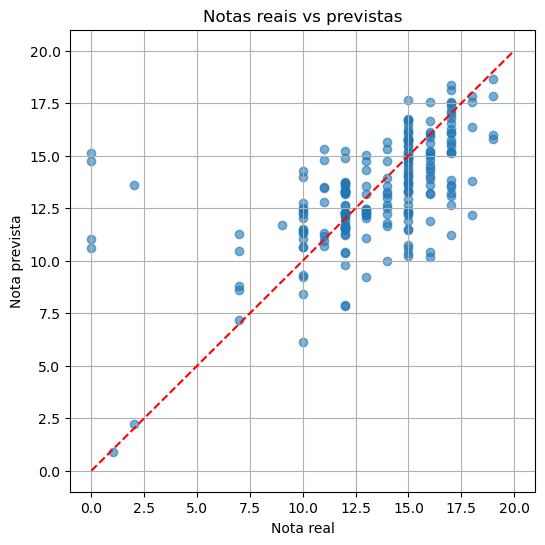

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, 20], [0, 20], 'r--')  # Linha ideal
plt.xlabel("Nota real")
plt.ylabel("Nota prevista")
plt.title("Notas reais vs previstas")
plt.grid(True)
plt.show()


nao é que tenha sido má, mas a anterior foi melhor... 

In [47]:
# Dataset completo
df = pd.read_csv("student_features_interval_all.csv")
X_raw = df.drop(columns=["Final Grade"])
y = df["Final Grade"]

# Pré-processamento igual ao modelo geral
X = preprocess_data_for_prediction(X_raw)

# Separar extremos (para treino do modelo especializado)
extremos_mask = (y <= 9) | (y >= 19)
X_extremos = X[extremos_mask]
y_extremos = y[extremos_mask]

print(f"Total de exemplos extremos: {len(y_extremos)}")


Pré-processamento: Dimensões iniciais dos novos dados: (1077, 20)
Pré-processamento: Removendo colunas irrelevantes...
  Coluna 'project_id' removida.
  Coluna 'group_id' removida.
  Coluna 'mention_handle' removida.
  Coluna 'last_minute_commits' removida.
  Coluna 'sum_lines_per_commit' removida.
Pré-processamento: Dimensões após remoção inicial: (1077, 15)
Pré-processamento: Criando features _log diretas...
  Feature 'sum_lines_added_log' criada.
  Feature 'total_issues_created_log' criada.
  Feature 'issue_participation_log' criada.
Pré-processamento: Iniciando engenharia de features (ratios, combinadas)...
  Feature 'merged_ratio_log' criada.
  Feature 'issue_resolution_rate_created_log' criada.
  Feature 'total_review_activity_log' criada.
Pré-processamento: Selecionando e ordenando features finais...
Pré-processamento: Dimensões finais dos dados prontos para o modelo (antes do scaler): (1077, 8)
Total de exemplos extremos: 73


In [48]:
from lightgbm import LGBMRegressor

modelo_extremos = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

modelo_extremos.fit(X_extremos, y_extremos)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 7
[LightGBM] [Info] Start training from score 7.561644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMRegressor(learning_rate=0.05, max_depth=4, n_estimators=500,
              random_state=42)

In [49]:
# Previsões com o modelo geral
y_pred_geral = model.predict(X_test)

# Identificar previsões que parecem estar nos extremos
usar_modelo_extremos = (y_pred_geral < 10) | (y_pred_geral > 18.5)

# Fazer nova previsão apenas nesses casos
X_test_extremos = X_test[usar_modelo_extremos]
y_pred_corrigida = y_pred_geral.copy()

# Substituir pelas previsões do modelo de extremos
y_pred_corrigida[usar_modelo_extremos] = modelo_extremos.predict(X_test_extremos)

# Avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_hibrido = mean_absolute_error(y_test, y_pred_corrigida)
rmse_hibrido = np.sqrt(mean_squared_error(y_test, y_pred_corrigida))

print(f"\nModelo Híbrido:")
print(f"MAE: {mae_hibrido:.2f}")
print(f"RMSE: {rmse_hibrido:.2f}")



Modelo Híbrido:
MAE: 1.66
RMSE: 2.63


boaaaa melhorou um bocadinho mais

In [50]:
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Usar o mesmo esquema de faixas
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]

# Cortar y_test pelas faixas
y_test_bins = pd.cut(y_test, bins=bins, labels=labels)

# DataFrame com resultados
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_corrigida,
    "faixa": y_test_bins
})

# Calcular MAE por faixa
mae_por_faixa_hibrido = results_df.groupby("faixa").apply(
    lambda g: mean_absolute_error(g["y_true"], g["y_pred"])
)
contagem_por_faixa = results_df["faixa"].value_counts().sort_index()

# Mostrar resultados
print("📊 MAE por faixa (modelo híbrido):")
print(mae_por_faixa_hibrido)

print("\n📊 Nº de exemplos por faixa:")
print(contagem_por_faixa)


📊 MAE por faixa (modelo híbrido):
faixa
Muito baixa    3.646397
Baixa          1.398613
Média          1.362054
Alta           1.519619
Muito alta     1.574890
dtype: float64

📊 Nº de exemplos por faixa:
faixa
Muito baixa     9
Baixa          83
Média          86
Alta           30
Muito alta      4
Name: count, dtype: int64


C:\Users\cataf\AppData\Local\Temp\ipykernel_24500\1240413351.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_por_faixa_hibrido = results_df.groupby("faixa").apply(
C:\Users\cataf\AppData\Local\Temp\ipykernel_24500\1240413351.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_por_faixa_hibrido = results_df.groupby("faixa").apply(


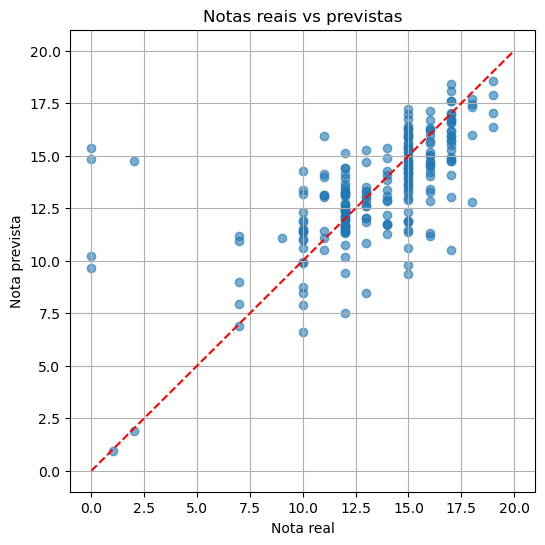

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, 20], [0, 20], 'r--')  # Linha ideal
plt.xlabel("Nota real")
plt.ylabel("Nota prevista")
plt.title("Notas reais vs previstas")
plt.grid(True)
plt.show()


vou testa-lo agora no testar_modelo.py

In [52]:
# Reaplicar stratificação
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

# Repetir divisão
stratifier = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_strat = stratifier.fit_transform(y.values.reshape(-1, 1)).ravel()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_strat, random_state=42
)

# Atribuir pesos às faixas
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_train_bins = pd.cut(y_train, bins=bins, labels=labels)

pesos_por_faixa = {
    "Muito baixa": 5,
    "Baixa": 1,
    "Média": 1,
    "Alta": 2,
    "Muito alta": 5
}
sample_weights = y_train_bins.map(pesos_por_faixa)

# Treinar modelo final
modelo_final = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

modelo_final.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 8
[LightGBM] [Info] Start training from score 12.886972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=1000,
              random_state=42)

In [53]:
import joblib
joblib.dump(modelo_final, "modelo_final_nota_aluno.pkl")


['modelo_final_nota_aluno.pkl']